In [34]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from keras import regularizers, optimizers
from keras.wrappers.scikit_learn import KerasClassifier

from math import sqrt
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import set_random_seed
from numpy.random import seed

from pandas_datareader import data as web

import datetime as dt
from IPython.display import display, HTML

In [18]:
#set seeds
seed(1)
set_random_seed(2)

## Retrieve Data through Web Scraping
(Yahoo Finance url is unstable, and the weblink may fail to process occasionally, if it happens, just rerun the cell until no error occurs)

In [19]:
# web scrap closing price from 1/1/2016 to the most recent day for every stock
stockNames = ['INTC', 'ORCL', 'MSFT', 'HON', 'CSCO', 'AMD', 'AAPL']

def get_stock(stock, start, end):
    return web.get_data_yahoo(stock, start, end)['Close']

stocks = []
#first stock is the target stock
for stock in stockNames:
    stocks.append(DataFrame(get_stock(stock, dt.datetime(2016, 1, 1), dt.datetime(2017, 11, 9))))

[*********************100%***********************]  1 of 1 downloaded

## Data Pre-Processing
We did a windowing since this a time series analysis and windowing can improve the outcome of the model training.

In [30]:
#size of window
num_lags = 2
#keep scalers to rescale back later
scalers = list()
#colnames to update df after windowing
colNames = list()

df = DataFrame()

for i in range(0, len(stocks)):
    # get difference between day 0 closing and day -1 closing
    stock = stocks[i] - stocks[i].shift()
    stock = stock.iloc[1:,:]
    
    #define scale to scale by
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(stock)
    scalers.append(scaler)
    
    if i == 0:
        #add the difference of target stock without lags
        df = concat([df, DataFrame(scaler.transform(stock))], axis = 1)
        colNames.append(stockNames[i]+"_0")
    
    for lag in range(1, num_lags+1):
        #windowing of size num_lags
        tmp = stock.shift(lag)
        tmp.fillna(0, inplace=True)
        tmp = DataFrame(scaler.transform(tmp))
        df = concat([df, tmp], axis = 1)
        colNames.append(stockNames[i]+"_"+str(lag))
        
#add correct names
df.columns = colNames
#add date index 
df.index = stocks[0].index[1:]

df.tail()

,INTC_0,INTC_1,INTC_2,ORCL_1,ORCL_2,MSFT_1,MSFT_2,HON_1,HON_2,CSCO_1,CSCO_2,AMD_1,AMD_2,AAPL_1,AAPL_2
Date,,,,,,,,,,,,,,,
2017-11-02,0.117744,0.393033,0.359868,-0.054863,0.064839,-0.116022,-0.272928,0.361003,0.180788,0.262472,0.106291,0.246493,0.362725,-0.367215,0.272726
2017-11-03,-0.263681,0.117744,0.393033,-0.079800,-0.054863,0.076244,-0.116022,0.319196,0.361003,-0.119306,0.262472,0.342685,0.246493,0.115247,-0.367215
2017-11-06,0.107794,-0.263681,0.117744,-0.014962,-0.079800,-0.096133,0.076244,0.186554,0.319196,0.171368,-0.119306,0.430862,0.342685,0.569076,0.115247
2017-11-07,0.014924,0.107794,-0.263681,0.064839,-0.014962,-0.043093,-0.096133,0.340821,0.186554,0.032538,0.171368,0.647295,0.430862,0.191124,0.569076
2017-11-08,-0.038142,0.014924,0.107794,0.032419,0.064839,-0.160222,-0.043093,0.447509,0.340821,0.054231,0.032538,0.370741,0.647295,0.020758,0.191124


In [31]:
#define training and test size
training_size = int(len(df) * 0.7)

#split into training and test sets
training_set, test_set = df.iloc[:training_size, :], df.iloc[training_size:, :]    
#split each set into predictors and label
training_input, training_output = training_set.iloc[:, 1:].values, training_set.iloc[:, :1].values
test_input, test_output = test_set.iloc[:, 1:].values, test_set.iloc[:, :1].values
# add extra row into test_input to predict tomorrow's price
test_input = np.concatenate((test_input, test_set.iloc[-1:, :-1].values))
#reshape input of the LSTM to be format [samples, time steps, features]
training_input = training_input.reshape(training_input.shape[0], 1, training_input.shape[1])
test_input = test_input.reshape(test_input.shape[0], 1, test_input.shape[1])
#ensure that training_input is a multiple of batch_size
batch_size = 21
training_input_1 = training_input
training_output_1 = training_output
while (len(training_input_1) % batch_size != 0):
    training_input_1 = training_input_1[1:]
    training_output_1 = training_output_1[1:]
    
num_inputs = len(stocks) * num_lags

## Model Architecture and Training
Here we used LSTM from the Keras package as our model. Our activation function is relu and optimiser is Adam optimization. The Adam optimization algorithm update network weights iterative based in training data. This gives it an advantage over the classical stochastic gradient.

In [70]:
#define model
model = Sequential()
model.add(LSTM(10, batch_input_shape=(batch_size, training_input_1.shape[1], training_input_1.shape[2]), stateful=True, return_sequences=True))
model.add(Activation('relu'))
model.add(LSTM(15, stateful=True))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
adam = optimizers.Adam(lr=0.03)
model.compile(loss='mean_squared_error', optimizer=adam)

model.summary()

model.fit(x=training_input_1, y=training_output_1, epochs=300, batch_size=batch_size, shuffle=False)

D:\Anaconda\lib\site-packages\tensorflow\python\util\tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (21, 1, 10)               1000      
_________________________________________________________________
activation_38 (Activation)   (21, 1, 10)               0         
_________________________________________________________________
lstm_39 (LSTM)               (21, 15)                  1560      
_________________________________________________________________
activation_39 (Activation)   (21, 15)                  0         
_________________________________________________________________
dropout_17 (Dropout)         (21, 15)                  0         
_________________________________________________________________
dense_29 (Dense)             (21, 1)                   16        
Total params: 2,576
Trainable params: 2,576
Non-trainable params: 0
_________________________________________________________________
Epoch 1/

315/315 [==============================] - 0s - loss: 0.0174     
Epoch 193/300
315/315 [==============================] - 0s - loss: 0.0174     
Epoch 194/300
315/315 [==============================] - 0s - loss: 0.0174     
Epoch 195/300
315/315 [==============================] - 0s - loss: 0.0174     
Epoch 196/300
315/315 [==============================] - 0s - loss: 0.0174     
Epoch 197/300
315/315 [==============================] - 0s - loss: 0.0174     
Epoch 198/300
315/315 [==============================] - 0s - loss: 0.0174     
Epoch 199/300
315/315 [==============================] - 0s - loss: 0.0174     
Epoch 200/300
315/315 [==============================] - 0s - loss: 0.0174     
Epoch 201/300
315/315 [==============================] - 0s - loss: 0.0174     
Epoch 202/300
315/315 [==============================] - 0s - loss: 0.0174     
Epoch 203/300
315/315 [==============================] - 0s - loss: 0.0174     
Epoch 204/300
315/315 [==============================]

## Training Outcome

In [71]:
#predict outcome using only batch size = 1
new_batch_size = 1
#get weights of trained model
weights = model.get_weights()
#build new model and set weights
new_model = Sequential()
new_model.add(LSTM(10, batch_input_shape=(new_batch_size, training_input_1.shape[1], training_input_1.shape[2]), stateful=True, return_sequences=True))
new_model.add(Activation('relu'))
new_model.add(LSTM(15, stateful=True))
new_model.add(Activation('relu'))
new_model.add(Dropout(0.1))
new_model.add(Dense(1))
new_model.set_weights(weights)

adam = optimizers.Adam(lr=0.03)
new_model.compile(loss='mean_squared_error', optimizer=adam)

training_predictions = new_model.predict(training_input, batch_size=new_batch_size)
training_predictions = scalers[0].inverse_transform(training_predictions)

for i in range(len(training_input)):
    training_predictions[i][0] += stocks[0].iloc[i:i+1,:].values[0][0]
    
rmse = sqrt(mean_squared_error(stocks[0].iloc[:training_size, :].values, training_predictions))
print('Training RMSE: %.4f' % rmse)

D:\Anaconda\lib\site-packages\tensorflow\python\util\tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Training RMSE: 0.0101


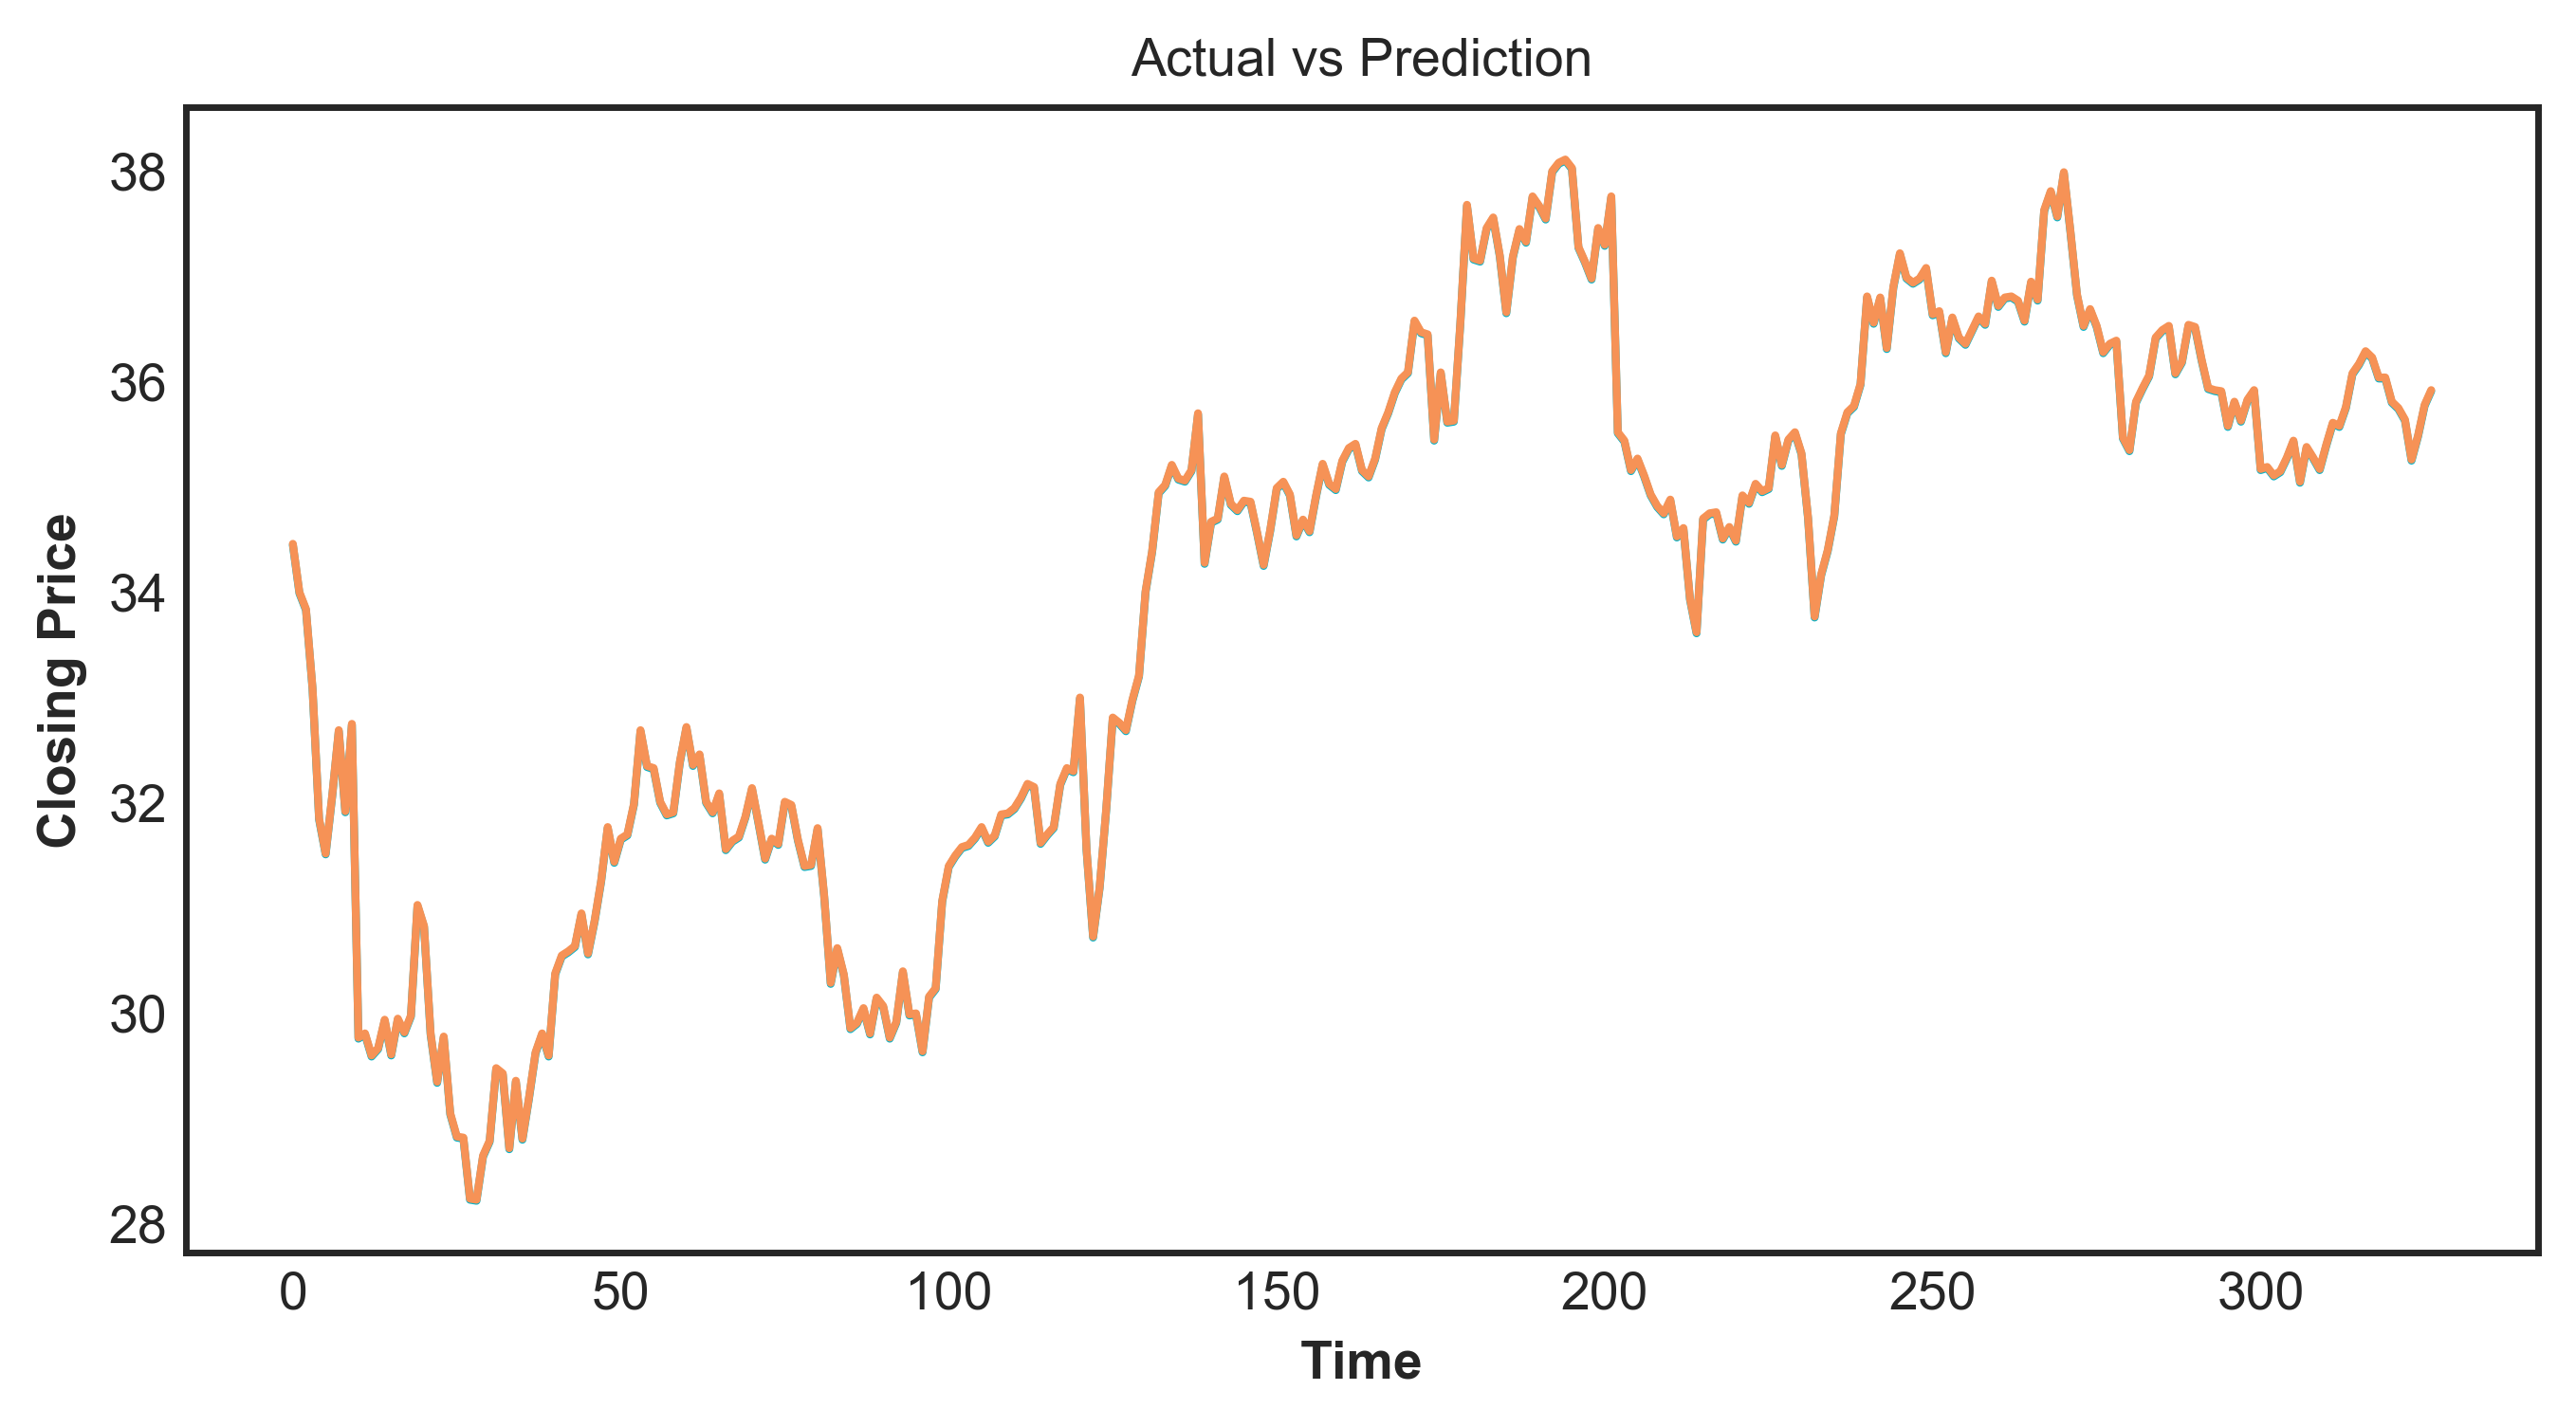

In [72]:
plt.style.use('seaborn-white')
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['figure.titlesize'] = 12

# Set an aspect ratio
width, height = plt.figaspect(0.5)
fig = plt.figure(figsize=(width,height), dpi=400)

plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Actual vs Prediction')
plt.plot(stocks[0].iloc[:training_size, :].values, color = "#00b3ca", label='Actual')
plt.plot(training_predictions, color = "#f69256", label='Prediction')
plt.show()

## Test Outcome

In [76]:
test_predictions = new_model.predict(test_input, batch_size=new_batch_size)
test_predictions = scalers[0].inverse_transform(test_predictions)

for i in range(training_size, len(df)+1):
    test_predictions[i-training_size][0] += stocks[0].iloc[i:i+1,:].values[0][0]

rmse = sqrt(mean_squared_error(stocks[0].iloc[training_size+1:, :].values, test_predictions[:-1]))
print('Test RMSE: %.4f' % rmse+' (%.4f' % (rmse/test_predictions[-1][0]*100) +'%)')

Test RMSE: 0.4450 (0.9528%)


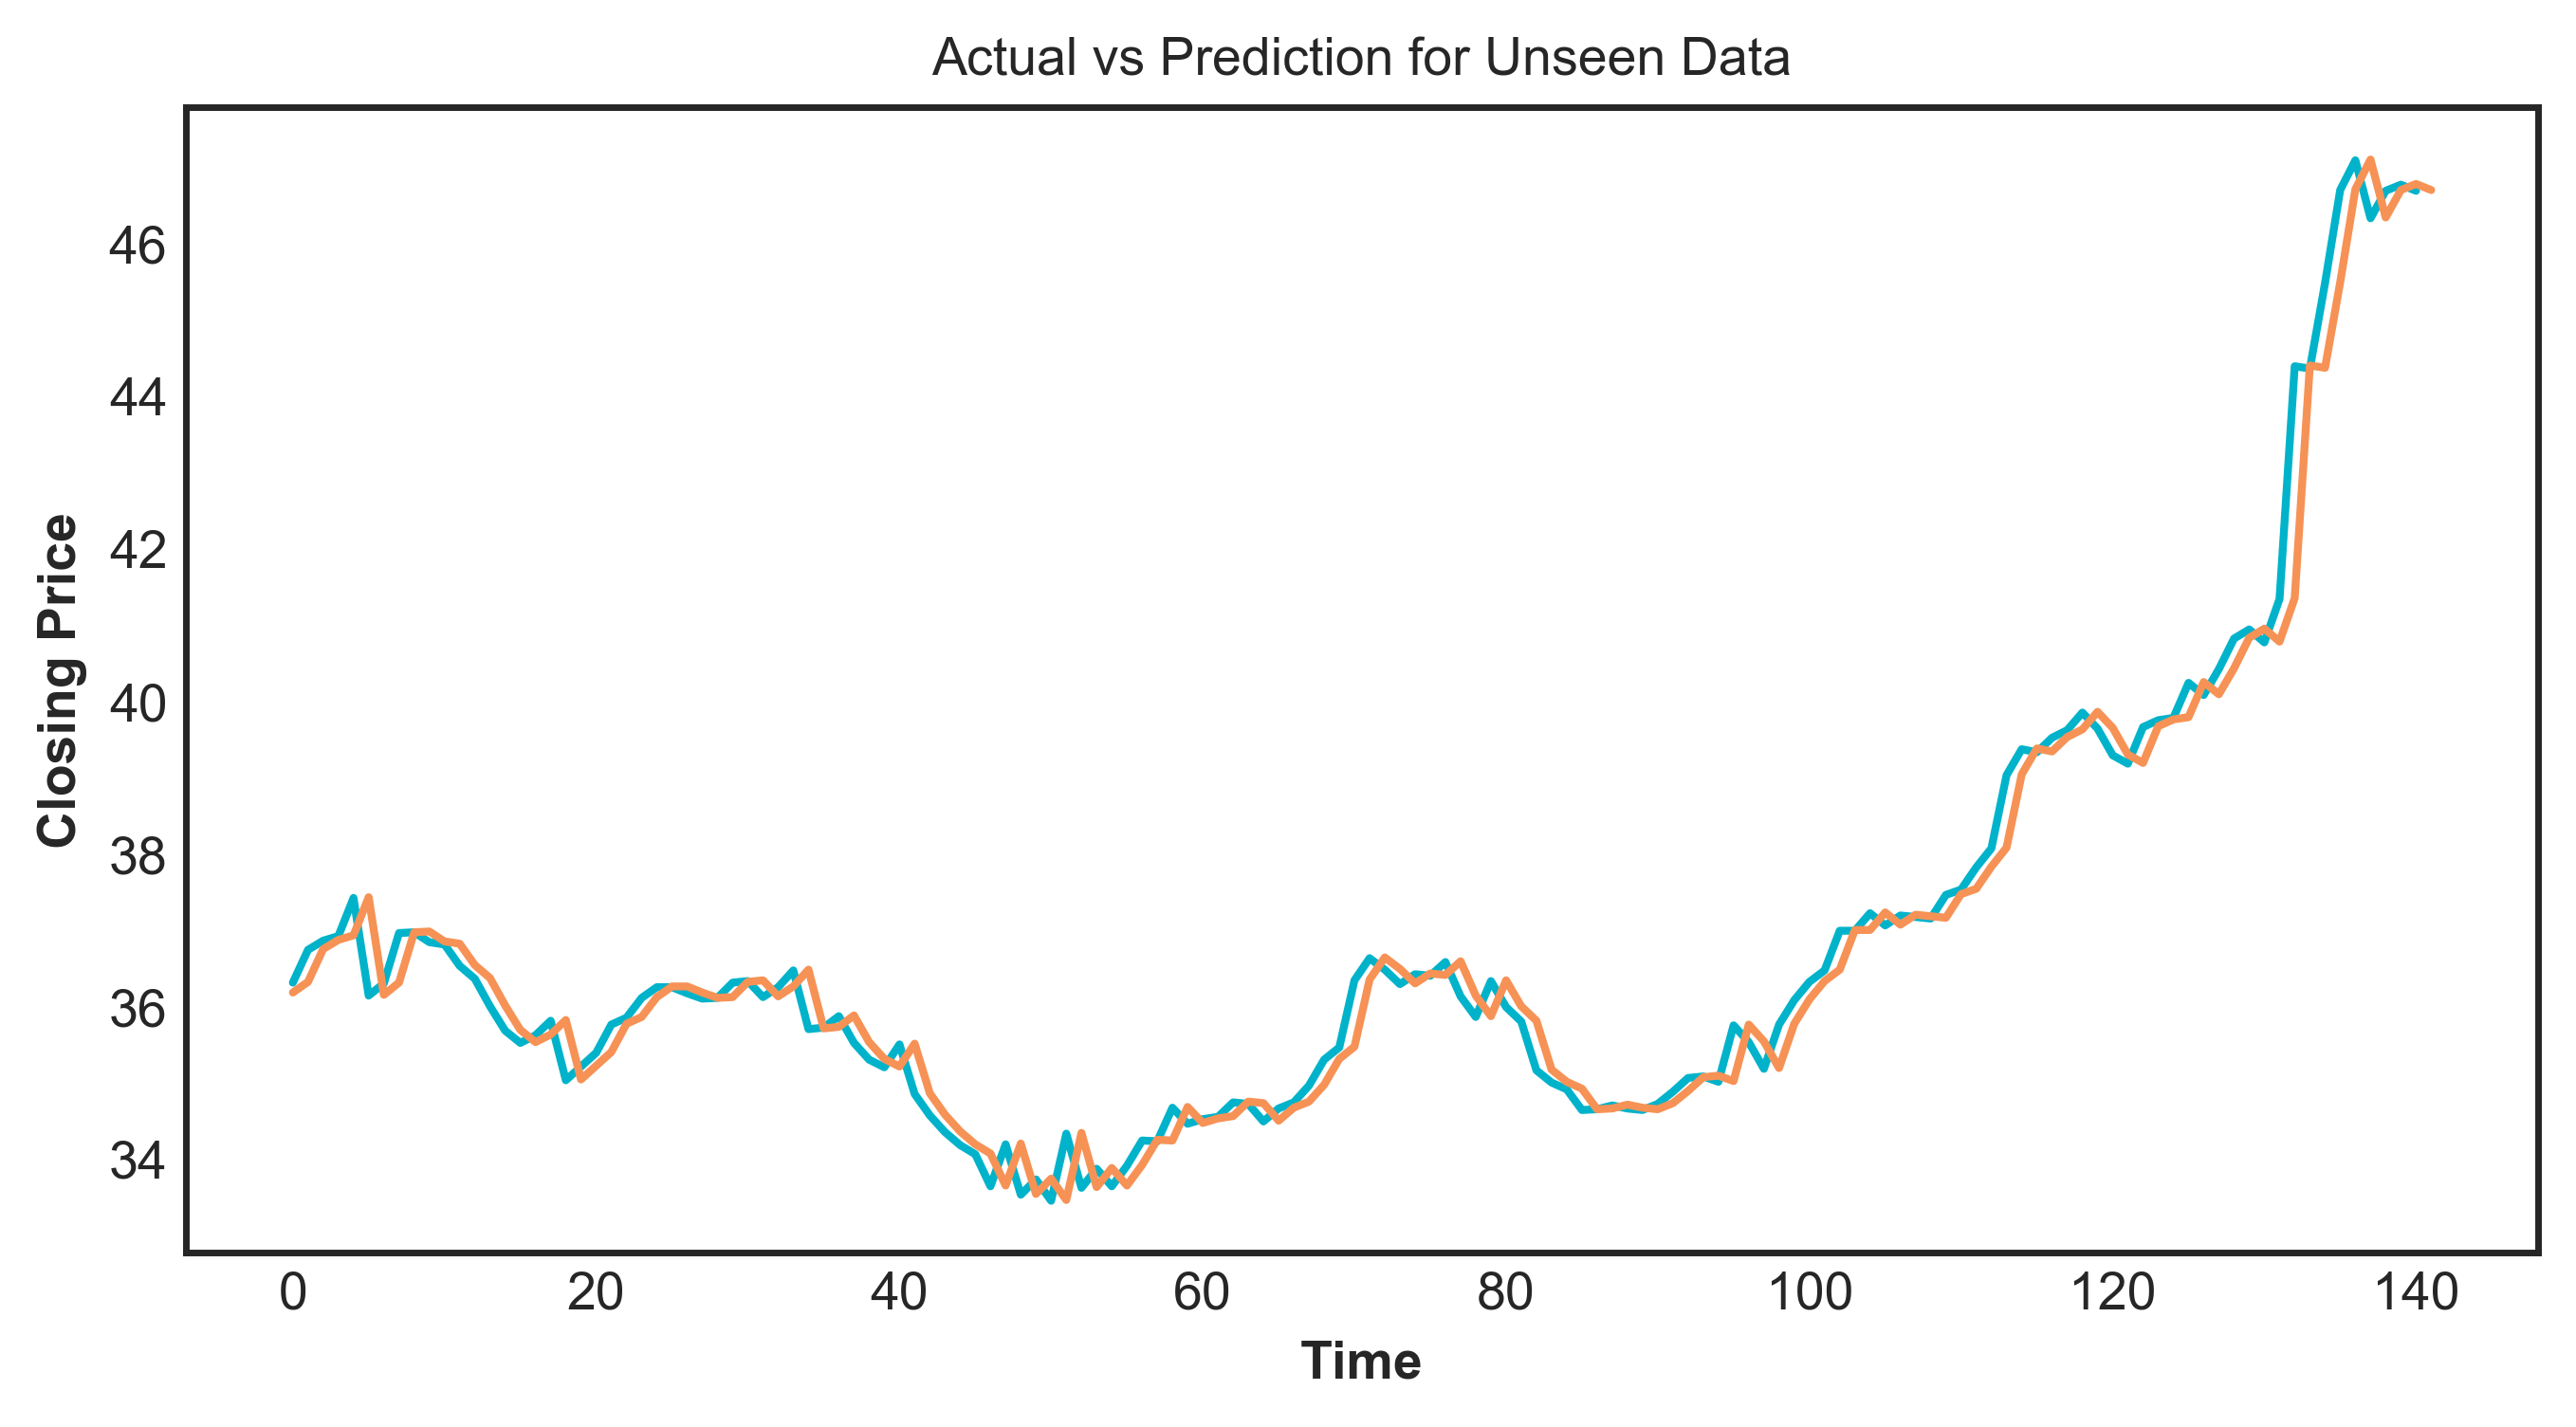

In [74]:
plt.style.use('seaborn-white')
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['figure.titlesize'] = 12

# Set an aspect ratio
width, height = plt.figaspect(0.5)
fig = plt.figure(figsize=(width,height), dpi=400)

plt.plot(stocks[0].iloc[training_size+1:, :].values, color = "#00b3ca",label='Actual')
plt.plot(test_predictions, color = "#f69256", label='Prediction')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('Actual vs Prediction for Unseen Data')
plt.show()

## Forecasted Price
10/11/2017 is the day we bought the stocks, while 9/11/2017 is the day where we predict a rise in price.

In [75]:
print("Closing Price 9/11/2017")
print(stocks[0].iloc[-1:,:1].values[0][0])
print('\n')
print("Predicted Closing Price on 10/11/2017")
print(test_predictions[-1][0])

Closing Price 9/11/2017
46.700001


Predicted Closing Price on 10/11/2017
46.7101
